In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 1. Caricamento dei dati salvati
print("Caricamento dati...")
#matrix_fqk = joblib.load('matrix_fqk.joblib')
matrix_pqk = joblib.load('data/real_quantum/matrix_pqk.joblib')
results = joblib.load('data/real_quantum/cluster_results.joblib')

# Recuperiamo le etichette e gli indici
#labels_fqk = results['labels_fqk']
labels_pqk = results['labels_pqk']
patient_indices = results['patient_indices']

# Se hai il CSV originale, caricalo per riavere le info cliniche (Età, Sesso, ecc.)
df_original = pd.read_csv('quantum-alz.csv', sep=";", decimal=',')


# Aggiungiamo i cluster al dataframe
#df_analyzed['Cluster_FQK'] = labels_fqk



Caricamento dati...


Il trucco matematico è questo:$$K_{ij} = e^{-\gamma \cdot d_{ij}^2} \implies -\ln(K_{ij}) = \gamma \cdot d_{ij}^2$$In pratica, il logaritmo naturale della matrice (cambiato di segno), è esattamente la matrice delle distanze (moltiplicata per una costante). Possiamo usare quella per ricalibrare tutto.


Fattore di scala applicato: 3.86


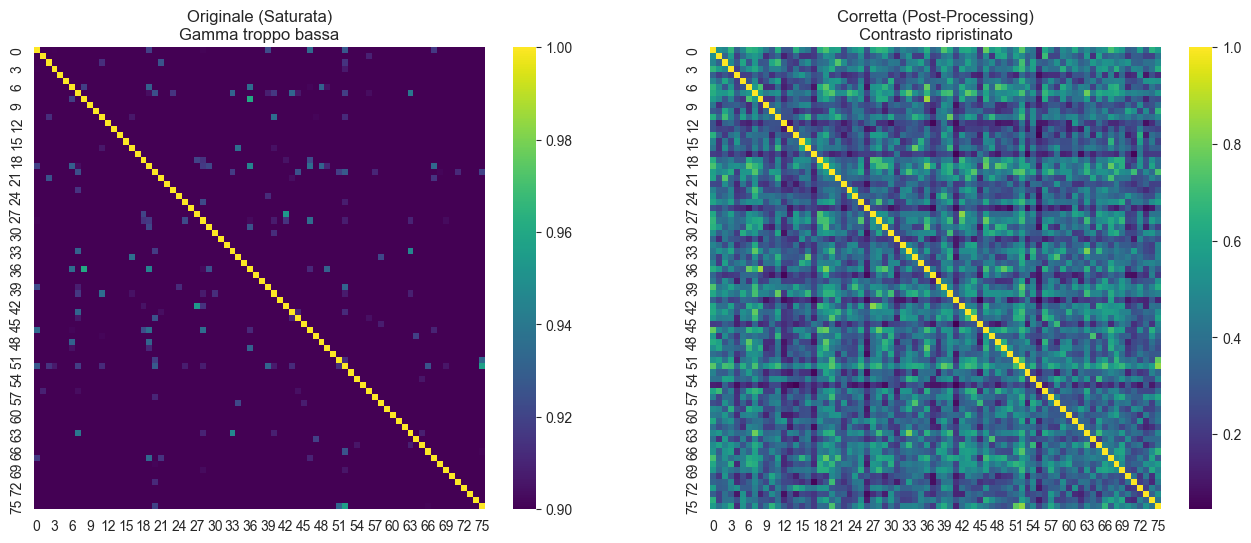

In [2]:
eps = 1e-15

# Clamping per sicurezza: assicuriamo che i valori non superino 1.0
matrix_pqk_safe = np.clip(matrix_pqk, a_min=eps, a_max=1.0)

# Invertiamo la formula gaussiana: D^2 proportional to -log(K)
dist_proxy = -np.log(matrix_pqk_safe)

# 3. Calcoliamo la nuova Gamma ottimale su queste distanze
# Vogliamo che la mediana delle distanze diventi significativa
mediana_dist = np.median(dist_proxy)
# Fattore di correzione: scaliamo in modo che l'esponente mediano sia circa 1
# Questo sposterà i valori della matrice attorno a e^-1 (0.36) invece di 0.99
scale_factor = 1.0 / (mediana_dist + eps)

print(f"Fattore di scala applicato: {scale_factor:.2f}")

# 4. Rigeneriamo la Matrice "Corretta"
# K_new = exp( - (1/mediana) * distanze )
matrix_pqk_fixed = np.exp(-dist_proxy * scale_factor)

# 5. Visualizza il Prima e Dopo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prima
sns.heatmap(matrix_pqk, cmap='viridis', ax=ax1, vmin=0.9, vmax=1.0)
ax1.set_title("Originale (Saturata)\nGamma troppo bassa")

# Dopo
sns.heatmap(matrix_pqk_fixed, cmap='viridis', ax=ax2)
ax2.set_title("Corretta (Post-Processing)\nContrasto ripristinato")

plt.show()




In [3]:
from sklearn.cluster import SpectralClustering

# --- 6. CLUSTERING SULLA MATRICE FIXED ---
print("Eseguo Spectral Clustering sulla matrice corretta...")
sc = SpectralClustering(n_clusters=3, affinity='precomputed', assign_labels='discretize', random_state=42)
labels_fixed = sc.fit_predict(matrix_pqk_fixed)

df_original['Cluster_PQK'] = labels_fixed
print("✅ Fatto! Nuovi cluster generati.")

Eseguo Spectral Clustering sulla matrice corretta...
✅ Fatto! Nuovi cluster generati.


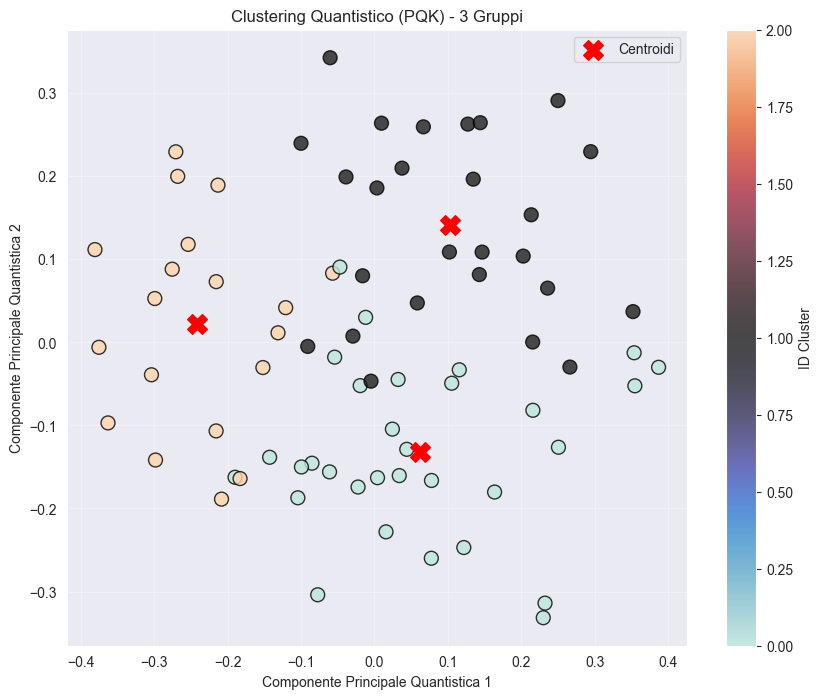

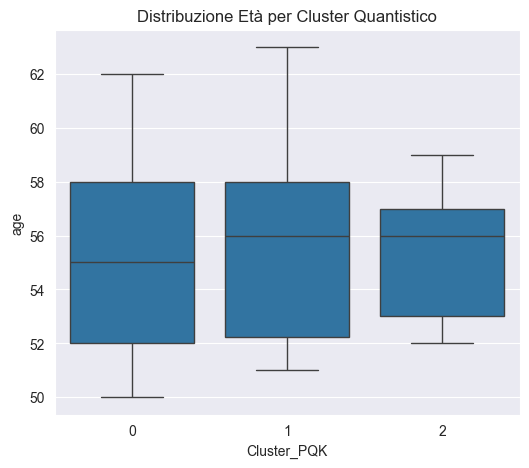

In [4]:
# Esempio 2: Kernel PCA Plot
kpca = KernelPCA(n_components=2, kernel='precomputed')
X_kpca = kpca.fit_transform(matrix_pqk)

df_viz = pd.DataFrame(X_kpca, columns=['Dim1', 'Dim2'])
df_viz['Cluster'] = labels_fixed


plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    df_viz['Dim1'],
    df_viz['Dim2'],
    c=df_viz['Cluster'],
    cmap='icefire',
    s=100,
    edgecolor='k',
    alpha=0.8
)


centroids = df_viz.groupby('Cluster').mean()
plt.scatter(centroids['Dim1'], centroids['Dim2'], c='red', marker='X', s=200, label='Centroidi')


plt.title(f"Clustering Quantistico (PQK) - {3} Gruppi")
plt.xlabel("Componente Principale Quantistica 1")
plt.ylabel("Componente Principale Quantistica 2")
plt.legend()
plt.colorbar(scatter, label='ID Cluster')
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(6, 5))
sns.boxplot(x='Cluster_PQK', y='age', data=df_original) # Assicurati che la colonna 'Age' esista
plt.title("Distribuzione Età per Cluster Quantistico")
plt.show()

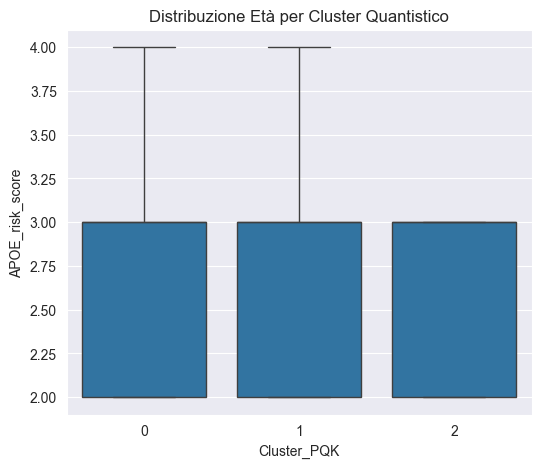

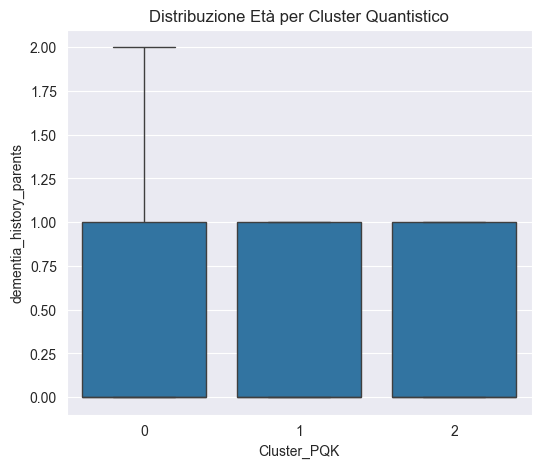

In [5]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Cluster_PQK', y='APOE_risk_score', data=df_original)
plt.title("Distribuzione Età per Cluster Quantistico")
plt.show()


plt.figure(figsize=(6, 5))
sns.boxplot(x='Cluster_PQK', y='dementia_history_parents', data=df_original)
plt.title("Distribuzione Età per Cluster Quantistico")
plt.show()

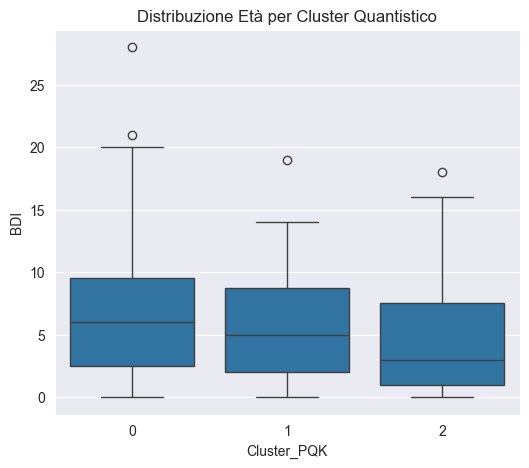

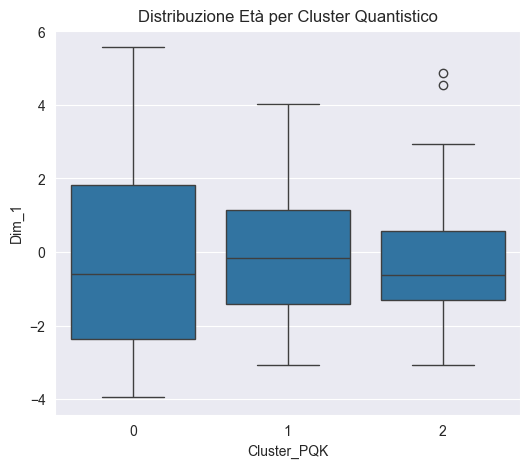

In [6]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Cluster_PQK', y='BDI', data=df_original)
plt.title("Distribuzione Età per Cluster Quantistico")
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(x='Cluster_PQK', y='Dim_1', data=df_original)
plt.title("Distribuzione Età per Cluster Quantistico")
plt.show()

In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


labels_std = df_original['Cluster']
# labels_quant = df['Cluster_Quantum']

# 1. Adjusted Rand Index (Il "Voto" alla somiglianza)
ari = adjusted_rand_score(labels_std, labels_fixed)

# 2. Normalized Mutual Information (Quanto uno spiega l'altro)
nmi = normalized_mutual_info_score(labels_std, labels_fixed)

print(f"Somiglianza dei Raggruppamenti (ARI): {ari:.3f}")
print(f"Informazione Condivisa (NMI): {nmi:.3f}")

Somiglianza dei Raggruppamenti (ARI): -0.017
Informazione Condivisa (NMI): 0.012


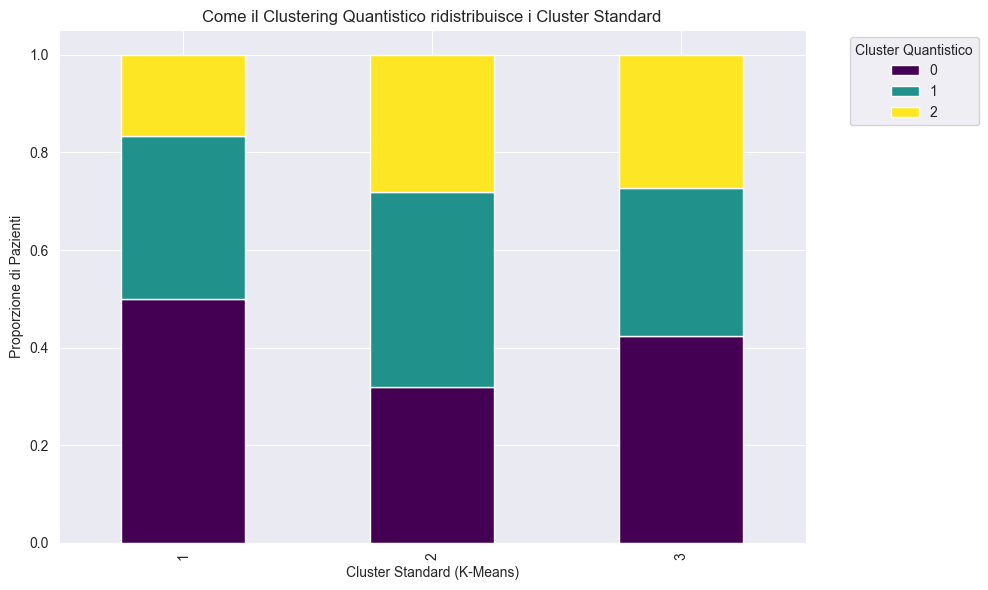

In [8]:
crosstab_norm = pd.crosstab(labels_std, labels_fixed, normalize='index')

crosstab_norm.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Come il Clustering Quantistico ridistribuisce i Cluster Standard")
plt.xlabel("Cluster Standard (K-Means)")
plt.ylabel("Proporzione di Pazienti")
plt.legend(title="Cluster Quantistico", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Confrontiamo matematicamente i risultati della simulazione e dell'esecuzione reale su IBM-torino

In [9]:
pqk_sim = pd.read_csv('df_pqk.csv', sep=",", decimal='.')

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


labels_sim = pqk_sim['Cluster_PQK_simulated']
# labels_quant = df['Cluster_Quantum']

# 1. Adjusted Rand Index (Il "Voto" alla somiglianza)
ari = adjusted_rand_score(labels_sim, labels_fixed)

# 2. Normalized Mutual Information (Quanto uno spiega l'altro)
nmi = normalized_mutual_info_score(labels_sim, labels_fixed)

print(f"Somiglianza dei Raggruppamenti (ARI): {ari:.3f}")
print(f"Informazione Condivisa (NMI): {nmi:.3f}")

Somiglianza dei Raggruppamenti (ARI): 0.295
Informazione Condivisa (NMI): 0.337
